In [146]:
import torch
import numpy as np
from torch import nn 
import torch.nn.functional as F 
from collections import OrderedDict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [147]:
import numpy as np
import argparse
from tqdm import tqdm 
from sklearn.datasets import load_wine
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity,rbf_kernel
from sklearn.metrics.cluster import normalized_mutual_info_score
from torch import nn,optim
import torch

In [148]:
#torch.manual_seed(0)

In [149]:
class GraphEncoder(nn.Module):
    def __init__(self,layers,clusters):
        super(GraphEncoder,self).__init__()
        
        self.layers = nn.Sequential(OrderedDict({
            "lin1": nn.Linear(layers[0],layers[1]),
            "sig1": nn.Sigmoid(),
            "lin2": nn.Linear(layers[1],layers[2]),
            "sig2": nn.Sigmoid(),
            "lin3": nn.Linear(layers[2],layers[3]),
            "sig3": nn.Sigmoid(),
            "lin4": nn.Linear(layers[3],layers[4]),
            "sig4": nn.Sigmoid(),
        }))
        
        
        self.clusters = clusters
        self.outputs = {}
        
        self.layers[0].register_forward_hook(self.get_activation("lin1"))
        self.layers[2].register_forward_hook(self.get_activation("lin2"))
        self.layers[4].register_forward_hook(self.get_activation("lin3"))
        
    def get_activation(self,name):
        def hook(module,input,output):
            self.outputs[name] = output
        return hook
    
    def forward(self,X):
        output = self.layers(X)
        return output
    
    def layer_activations(self,layername):
       # print(torch.sigmoid(self.outputs[layername]).shape)
        return torch.mean(torch.sigmoid(self.outputs[layername]),dim=0)
    
    def sparse_result(self,rho,layername):
        rho_hat = self.layer_activations(layername)
        return rho * np.log(rho) - rho * torch.log(rho_hat) + (1 - rho) * np.log(1 - rho) \
                - (1 - rho) * torch.log(1 - rho_hat)
    
    def kl_div(self,rho):
        first = torch.mean(self.sparse_result(rho,"lin1"))
        second = torch.mean(self.sparse_result(rho,"lin2"))
        return first + second
    
    def get_index_by_name(self,name):
        return list(dict(self.layers.named_children()).keys()).index(name)
    
    def loss(self,x_hat,x,beta,rho):
        loss = F.mse_loss(x_hat,x) + beta*self.kl_div(rho)
        return loss 
    
    def get_cluster(self):
        kmeans = KMeans(n_clusters = self.clusters).fit(self.outputs["lin2"].detach().cpu().numpy())
        self.centroids = kmeans.cluster_centers_
        return kmeans.labels_
    
        
                

In [150]:
class SAE(nn.Module):
    def __init__(self,input_layer,hidden_layer):
        super(SAE,self).__init__()
        self.layers = [input_layer] + [hidden_layer] + [input_layer]
#         print(self.layers)
        self.net = nn.Sequential(OrderedDict({
            "lin1": nn.Linear(self.layers[0],self.layers[1]),
            "sig1":nn.Sigmoid(),
            "lin2": nn.Linear(self.layers[1],self.layers[2]),
            "sig2":nn.Sigmoid()
        }))
        
        self.outputs = {}
        
        self.net[0].register_forward_hook(self.get_activation("lin1"))
        
        
    def get_activation(self,name):
        def hook(module,input,output):
            self.outputs[name] = output
        return hook

    def forward(self,X):
        output = self.net(X)
        return output


    def layer_activations(self,layername):
        return torch.mean(torch.sigmoid(self.outputs[layername]),dim=0)

    def sparse_result(self,rho,layername):
        rho_hat = self.layer_activations(layername)
        return rho * np.log(rho) - rho * torch.log(rho_hat) + (1 - rho) * np.log(1 - rho) \
            - (1 - rho) * torch.log(1 - rho_hat)

    def kl_div(self,rho):
        return torch.mean(self.sparse_result(rho,"lin1"))

    def loss(self,x_hat,x,rho,beta):
        loss = F.mse_loss(x_hat,x) + beta*self.kl_div(rho)
        return loss
                    

In [151]:
args = {
    "dataset": "wine",
    "layers":[128,64,128],
    "beta": 0.01,
    "rho":0.5,
    "lr": 0.01,
    "epoch": 200,
    "device":"gpu"
}

device = torch.device("cuda" if args["device"] == "gpu" else "cpu")

                      

## Stacked Auto encoder

In [155]:
def main():
    if args["dataset"].lower() == "wine":
        data = load_wine()
    else:
        raise Exception("Invalid Dataset")
    
    X  = data.data
    y = data.target
    k = len(np.unique(y))
    
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    
    S = rbf_kernel(X,X,gamma=2)
    
    D  = np.diag(1.0/S.sum(axis=1))
    
    X_train = torch.tensor(D.dot(S)).float().to(device)
    
    layers = [len(X_train)] + args["layers"] + [len(X_train)]
    
    model = GraphEncoder(layers,k).to(device)
    optimizer  = optim.Adam(model.parameters(),lr=args["lr"])
    
    with tqdm(total= args["epoch"]) as tq:
        for epoch in range(1,args["epoch"] +1):
            optimizer.zero_grad()
            X_hat = model(X_train)
            loss = model.loss(X_hat,X_train, args["beta"],args["rho"])
            nmi = normalized_mutual_info_score(model.get_cluster(),y,average_method="arithmetic")
            loss.backward()
            optimizer.step()
            
            tq.set_postfix(loss=loss,nmi ="{:.3f}".format(nmi))
            tq.update()
        print(model.get_cluster())
    return model

if __name__ == "__main__":
    model = main()

100%|██████████| 200/200 [00:05<00:00, 38.12it/s, loss=tensor(6.2077e-05, device='cuda:0', grad_fn=<AddBackward0>), nmi=0.858]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 0 0 0 0 0 0 2 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [156]:
hyper = {
    "beta": 0.05,
    "rho":0.2,
    "lr": 0.01,
    "epoch": 200,
    "gamma":2

}

data = load_wine()
X = data.data
y = data.target
k = len(np.unique(y))
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
S = rbf_kernel(X,X,hyper["gamma"])
D  = np.diag(1.0/S.sum(axis=1))
X_train = torch.tensor(D.dot(S)).float().to(device)

layers = [128,64,32,16]
inp_layers = [178,128,64,32]


for inp_layer,hidden_layer in zip(inp_layers,layers):
    model = SAE(inp_layer,hidden_layer).to(device)
    optimizer = optim.Adam(model.parameters(),lr=hyper["lr"])
    with tqdm(total=hyper["epoch"]) as tq:
        for epoch in range(1,hyper["epoch"]+1):
            optimizer.zero_grad()
            x_hat = model(X_train)
            loss = model.loss(x_hat,X_train,hyper["rho"],hyper["beta"])
            loss.backward()
            optimizer.step()
            
            tq.set_postfix(loss=loss)
            tq.update()
    print(model.outputs["lin1"].shape)
    X_train = model.outputs["lin1"].detach()

    
    
           
kmeans = KMeans(n_clusters=k).fit(X_train.detach().cpu().numpy())
labels = kmeans.labels_
nmi = normalized_mutual_info_score(labels,y,average_method="arithmetic")
print(nmi)    



 28%|██▊       | 56/200 [00:00<00:00, 290.95it/s, loss=tensor(1.3317, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([178, 128])


 28%|██▊       | 56/200 [00:00<00:00, 286.05it/s, loss=tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([178, 64])


 28%|██▊       | 56/200 [00:00<00:00, 285.08it/s, loss=tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([178, 32])


100%|██████████| 200/200 [00:00<00:00, 295.48it/s, loss=tensor(0.1397, device='cuda:0', grad_fn=<AddBackward0>)]


torch.Size([178, 16])
0.8130458076130239


In [129]:
X_train

tensor([[-0.3268, -0.3927, -0.3628,  ..., -0.3250, -0.3502, -0.4169],
        [-0.3269, -0.3927, -0.3629,  ..., -0.3257, -0.3507, -0.4174],
        [-0.3262, -0.3930, -0.3618,  ..., -0.3246, -0.3498, -0.4173],
        ...,
        [-0.3215, -0.3909, -0.3597,  ..., -0.3208, -0.3504, -0.4181],
        [-0.3221, -0.3907, -0.3595,  ..., -0.3206, -0.3511, -0.4178],
        [-0.3207, -0.3911, -0.3594,  ..., -0.3212, -0.3503, -0.4180]],
       device='cuda:0')

In [138]:
gap = X_train.cpu().numpy()

In [139]:
sim =np.dot(D,S)
ev =np.dot(sim,gap)
evalue = np.divide(ev,gap)

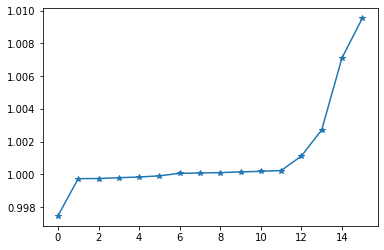

In [157]:
eigen_values =sorted(evalue.mean(axis=0))
plt.plot(eigen_values,marker="*")

In [113]:
data = load_wine()
X = data.data
y = data.target
k = len(np.unique(y))
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
S = cosine_similarity(X,X)
D  = np.diag(1.0/S.sum(axis=1))
X_train = torch.tensor(D.dot(S)).float().numpy()
kmeans.fit(X_train)

KMeans(n_clusters=3)

In [83]:
nmi = normalized_mutual_info_score(kmeans.labels_,y,average_method="arithmetic")
print(nmi)    

0.6351524906645798


In [14]:
data


{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
         1.185e+03],
        ...,
        [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
         8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
         8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
         5.600e+02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1